<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [2.3 First Order Model for a Single Heater](https://jckantor.github.io/cbe30338-2021/02.03-First-Order-Model-for-a-Single-Heater.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [2.5 Two State Model for a Single Heater](https://jckantor.github.io/cbe30338-2021/02.05-Two-State-Model-for-a-Single-Heater.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/02.04-Model-Identification.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/02.04-Model-Identification.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

In [ ]:
# IMPORT DATA FILES USED BY THIS NOTEBOOK
import os,  requests

file_links = [("data/Model_Data.csv", "https://jckantor.github.io/cbe30338-2021/data/Model_Data.csv")]

# This cell has been added by nbpages. Run this cell to download data files required for this notebook.

for filepath, fileurl in file_links:
    stem, filename = os.path.split(filepath)
    if stem:
        if not os.path.exists(stem):
            os.mkdir(stem)
    if not os.path.isfile(filepath):
        with open(filepath, 'wb') as f:
            response = requests.get(fileurl)
            f.write(response.content)


# 2.4 Model Identification for the Temperature Control Lab

Models are essential for feedback control. It may be difficult to understand where and how the model was incorporated into the control system design, and the model may be just a simplistic cause-and-effect understanding of process operation, but be assured that somewhere in the control system is an embedded understanding of process operation.

The notebook is deep dive in creating models for the dynamic response of the Temperature Control Lab to power inputs and external disturbances. The survey of models include:

* Empirical models, single-input single-output
    * Linear first-order
    * Linear first-order with dead-time
   

* Energy balance models
    * Single-input, single-output
        * First order 
        * Second order
    * Multi-input, multi-output
        * Fourth order


* State space models

## 2.4.1 Learning Goals

After completing this notebook, students will know how to

* Explain the term **Model Identification**
* Read and display data previously saved in `.csv` format.
* Explain the difference between **empirical** and **first-principles** modeling.
* Explain a **step test** experiment
* Fit the results of a step test experiment to first-order empirical models with **gain**, **time constant**, and **time delay**.
* Fit a first-order energy balance model to step test data for the Temperature Control Lab.
* Fit energy balance models of increasing complexity to step test data for the Temperature Control Lab.
* Describe terms appearing in a **linear state space model**.

## 2.4.2 What is model identification?

**Model identification** is the discipline of developing, fitting, and assessing the performance of mathematical models for control applications. We need ...

* Models
    * **Empirical** models where parameters are related to features in the response
    * **First-principle** models where parameters are related to underlying physical and chemical principles


* Data
    * **Step test**
    * and many others


* Fitting
    * **Eye test:** 
    * **Least squares:** Minimize the sum of squares of the different between predictions and measurements
    * and many others


* Assessment
    * Examine residuals for systematic error or bias
    * Do the data fitting experiments incorporate all of the important operating regimes and situations?
    * Will the fitted model enable us to achieve the required level of control performance?
    * *Horses for courses*

## 2.4.3 Accessing experimental data

Data acquired through normal process operation or experimentation will normally be accessed from a process database. Here we demonstrate reading data stored previously stored in a `.csv` file by a process historian.

### 2.4.3.1 Read data into a Pandas DataFrame

[Pandas](https://pandas.pydata.org/) is one of the most important and widely used Python libraries for data analysis and manipulation. Here we use the library to access a `.csv` file containing previously collected data from a step test of the Temperature Control Lab.

,T1,T2,Q1,Q2
Time,,,,
0.0,21.221,21.446,50.0,0.0
10.0,21.253,21.511,50.0,0.0
20.0,22.188,21.575,50.0,0.0
30.0,23.477,21.672,50.0,0.0
40.0,24.991,21.897,50.0,0.0
...,...,...,...,...
560.0,52.803,36.722,50.0,0.0
570.0,52.803,36.786,50.0,0.0
580.0,52.803,36.754,50.0,0.0


<AxesSubplot:xlabel='time / seconds'>

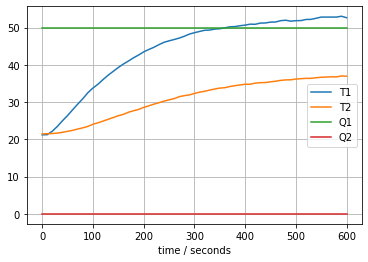

In [290]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# read data file from the Github repository into a Pandas dataframe
data_location = "https://jckantor.github.io/cbe30338-2021/data/Model_Data.csv"
expt = pd.read_csv(data_location)

# set time index
expt = expt.set_index("Time")
t_expt = expt.index

# display data in tabular format
display(expt)

# simple plotting
expt.plot(grid=True, xlabel="time / seconds")

<hr>

**Study Question:**  "Break free from Excel". This exercise demonstrates a technique that you may find useful in your other coursework, particularly the Junior and Senior lab courses. The code cell below contains a link that will export [data stored in a Google Sheet](https://docs.google.com/spreadsheets/d/1rV_oimh-GCYNP-xRP1HNrLvh7P4jZBSmwuqG3VPIaB0/edit?usp=sharing) as a `.csv` file. The file was previously created and share access set for viewing by anyone with a link. Use the Pandas library to read the data into a data frame, display the data table, set the data frame index to the column labeled `Time`, and plot the data. 

<hr>

In [291]:
google_sheet_id = "1rV_oimh-GCYNP-xRP1HNrLvh7P4jZBSmwuqG3VPIaB0"
google_csv_download = f"https://docs.google.com/spreadsheets/d/{google_sheet_id}/gviz/tq?tqx=out:csv"

# write your code here

## 2.4.4 Comparing experimental data to model predictions

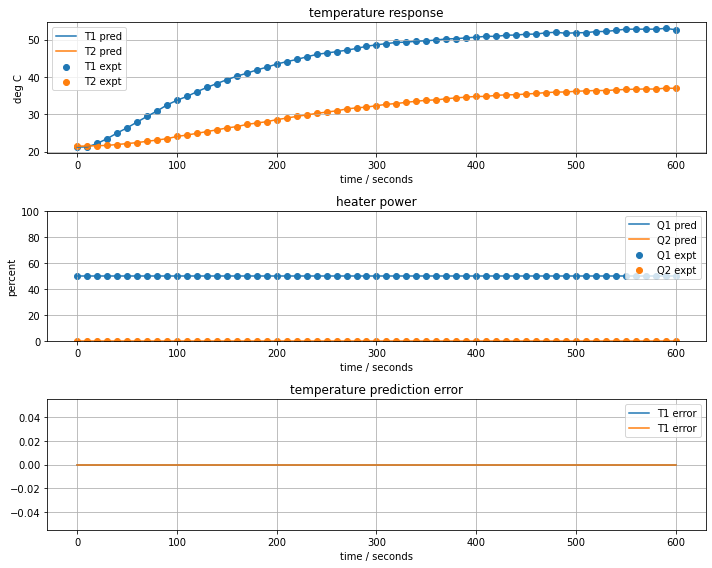

In [299]:
# create a function to compare two data sets
def plot_data(expt, pred):
    t_expt = expt.index
    
    # create a 3 x 1 grid of plot axes
    fig, ax = plt.subplots(3, 1, figsize=(10,8))
    
    # first plot axes
    ax[0].scatter(t_expt, expt["T1"], label="T1 expt")
    ax[0].scatter(t_expt, expt["T2"], label="T2 expt")
    ax[0].plot(t_expt, pred["T1"], label="T1 pred")
    ax[0].plot(t_expt, pred["T2"], label="T2 pred")
    ax[0].set_ylabel("deg C")
    ax[0].set_title("temperature response")

    # second plot axes
    ax[1].scatter(t_expt, expt["Q1"], label="Q1 expt")
    ax[1].scatter(t_expt, expt["Q2"], label="Q2 expt")
    ax[1].plot(t_expt, pred["Q1"], label="Q1 pred")
    ax[1].plot(t_expt, pred["Q2"], label="Q2 pred")
    ax[1].set_ylim([0, 100])
    ax[1].set_ylabel("percent")
    ax[1].set_title("heater power")
    
    # third plot axes
    ax[2].plot(t_expt, pred["T1"]-expt["T1"], label="T1 error")
    ax[2].plot(t_expt, pred["T2"]-expt["T2"], label="T1 error")
    ax[2].set_title("temperature prediction error")
    
    # things to do for every plot axes
    for a in ax:
        a.grid(True)
        a.set_xlabel("time / seconds")
        a.legend()
        
    plt.tight_layout()
    
    # return list of axes so to allow additional information to be added
    return ax
    
# demonstrate by comparing experimental data to itself
plot_data(expt, expt);

## 2.4.5 Empirical Modeling

### 2.4.5.1 First order gain and time constant

We have previously derived a model for the response of the Temperature Control Lab to a step change in input as

$$\frac{dT_1}{dt} = -\frac{1}{\tau}(T_1 - T_{amb})+ \frac{K}{\tau}\bar{u}_1$$

where the gain $K$ and time constant $\tau$ are given by the

\begin{align}
\tau = \frac{C_p}{U_a} \qquad
K = \frac{\alpha P_1}{U_a}
\end{align}

If we assume an initial condition $T_1(0) = T_{amb}$

\begin{align}
T_1(t) & = T_{amb}  + K\bar{u}_{1}(1 - e^{-(t-t_0)/\tau})
\end{align}

For estimates of $K$ and $\tau$ we can construct an estimated response and compare to the observed response.

array([<AxesSubplot:title={'center':'temperature response'}, xlabel='time / seconds', ylabel='deg C'>,
       <AxesSubplot:title={'center':'heater power'}, xlabel='time / seconds', ylabel='percent'>,
       <AxesSubplot:title={'center':'temperature prediction error'}, xlabel='time / seconds'>],
      dtype=object)

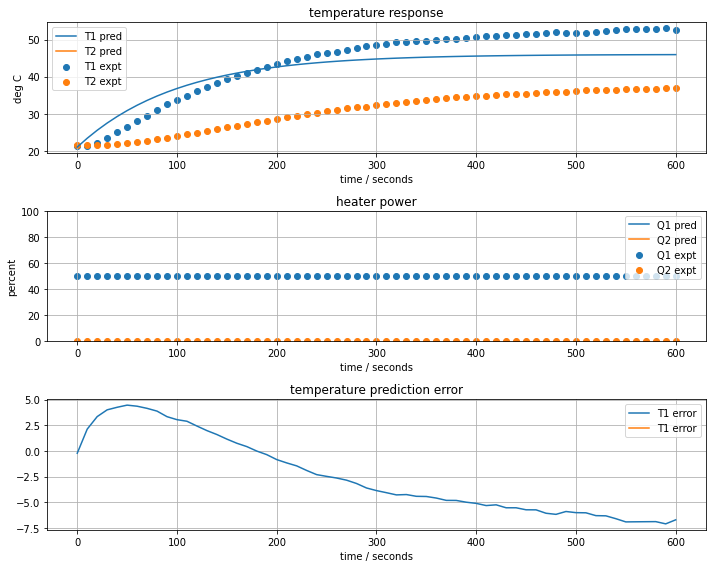

In [320]:
# known parameters
T_amb = 21
u1bar = expt["Q1"].mean()

# adjustable model parameters
K = 0.5
tau = 100

# create a prediction
pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
pred["T1"] = T_amb + K*u1bar*(1 - np.exp(-t_expt/tau))

# compare prediction to experiment
plot_data(expt, pred)

<hr>

**Study Question:** By trial and error, attempt to find values for the gain $K$ and time constant $\tau$ that describe the step response.

<hr>

Obviously, it would useful to have some way of finding 'optimal' values for $K$ and $\tau$. For this purpose, we will encapsulate the predition inside of a function that returns some metric of optimality. In this case we will use the sum of squares of the prediction error.




208.78461640829886

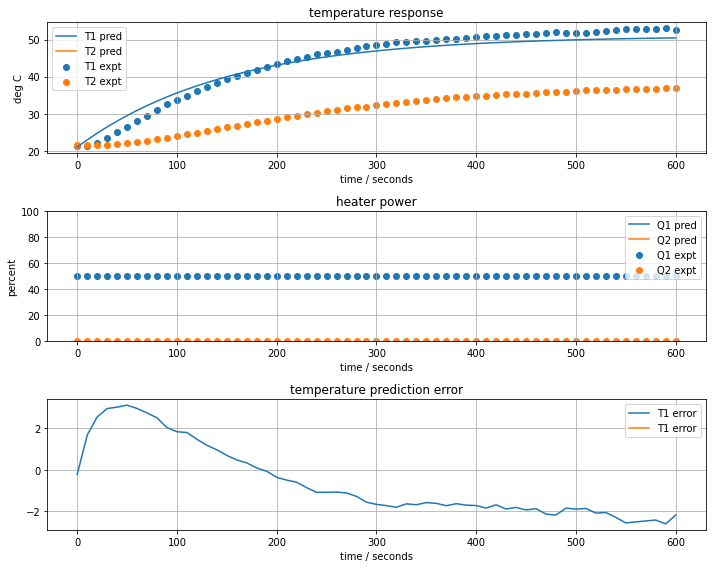

In [321]:
# parameter values and units
T_amb = 21                 # deg C
u1bar = expt["Q1"].mean()  

# adjustable parameters
K = 0.6
tau = 150

param = [K, tau]

def model_gain_timeconstant(param, plot=False):
    K, tau = param
    
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T1"] = T_amb + K*u1bar*(1 - np.exp(-t_expt/tau))
    
    # compute sum of squares error
    err = ((pred["T1"] - expt["T1"])**2).sum()
    
    if plot:
        plot_data(expt, pred)
        
    return err
        
model_gain_timeconstant(param, plot=True)

Next we'll use the `least_squares` routine from `scipy.optimize` to find optimal values of the parameters.

[  0.62795966 150.00828874]


133.34832212718578

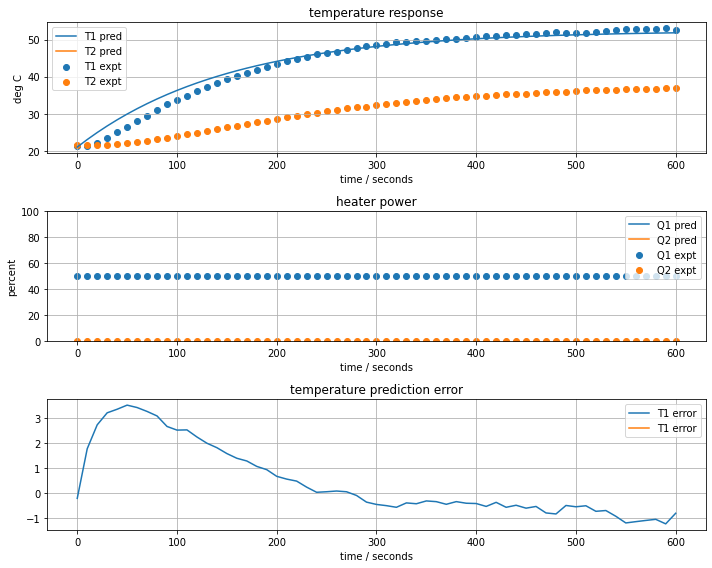

In [322]:
from scipy.optimize import least_squares

result = least_squares(model_gain_timeconstant, param)
print(result.x)
model_gain_timeconstant(result.x, plot=True)

<hr>

**Study Question:** Chose a different criterion to determine optimal parameter values and implement it in the code cell below. How much did this affect the reported parameter values? 

<hr>


### 2.4.5.2 First order with time delay

\begin{align}
T_1(t) & = T_{amb}  + K\bar{u}_{1}(1 - e^{-(t-t_{delay})/\tau})
\end{align}

196.05305266280436

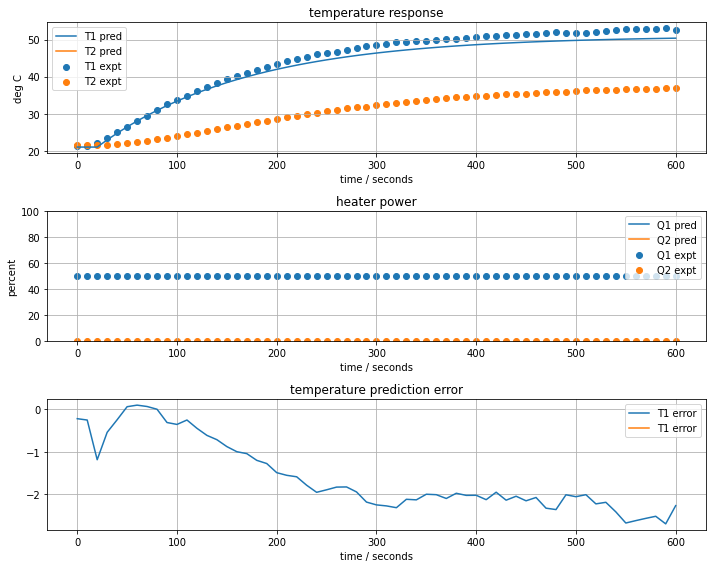

In [352]:
# parameter values and units
T_amb = 21                 # deg C
u1bar = expt["Q1"].mean()


# adjustable parameters
K = 0.6
tau = 150
t_delay = 20

param = [K, tau, t_delay]

def model_gain_delay(param, plot=False):
    K, tau, t_delay = param
    
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    
    T1 =  [T_amb + K*u1bar*(1 - np.exp(-(t-t_delay)/tau)) if t > t_delay else T_amb for t in t_expt]
    pred["T1"] = T1
    
    # compute sum of squares error
    err = ((pred["T1"] - expt["T1"])**2).sum()
    
    if plot:
        plot_data(expt, pred)
        
    return err
        
model_gain_delay(param, plot=True)

[  0.6453641  150.00225665  20.0050653 ]


7.906774940754739

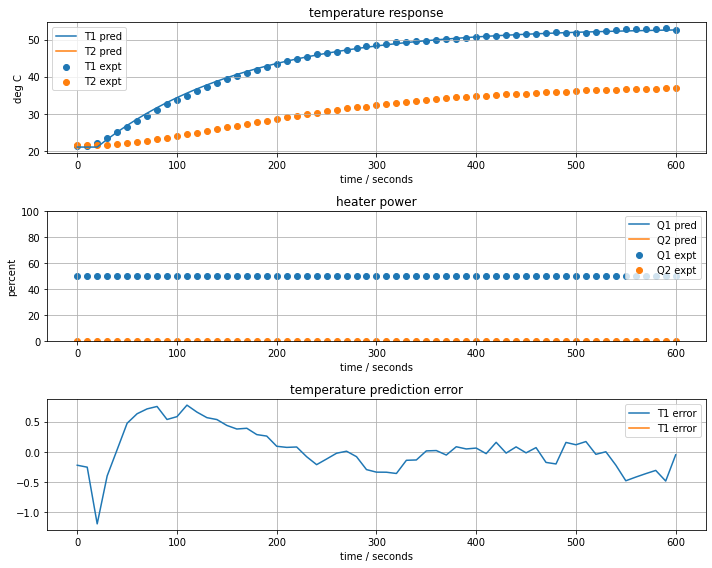

In [353]:
result = least_squares(model_gain_delay, param)
print(result.x)
model_gain_delay(result.x, plot=True)

## 2.4.6 Compute first-order model predictions

We previously developed a model comprising a single differential equation for the temperature response of a heater/sensor assembly. Given $u_1(t)$ and an initial condition $T_{amb}$, the heater/sensor temperature is given by 

$$\frac{dT_1}{dt} = -\frac{U_a}{C_p}T_1 + \frac{\alpha P_1}{C_p} u_1(t) + \frac{U_a}{C_p}T_{amb}$$

Several of the key parameters are known. These include $\alpha$ which was determined by direct measurement, $P1$ which is set in the Arduino firmware. We  assume the ambient temperature $T_{amb}$ is measurable and known. 

The unknown parameters are the heat capacity $C_p$ and heat transfer coefficient $U_a$. We wish to find values of the unknown parameters that allow the model response to mimic responses measured by experiment.

Here we show a simulation of this model.

In [332]:
# parameter values and units
T_amb = 21             # deg C
P1 = 200               # P1 units
P2 = 100               # P2 units
alpha = 0.00016        # watts / (units P1 * percent U1)

# input function
def u1(t):
    return np.interp(t, t_expt, Q1_expt)

def u2(t):
    return np.interp(t, t_expt, Q2_expt)

The unknown parameters are the heat capacity $C_p$ and heat transfer coefficient $U_a$. We wish to find values of the unknown parameters that allow the model response to mimic responses measured by experiment.

Here we show a simulation of this model.

553.3968853415417

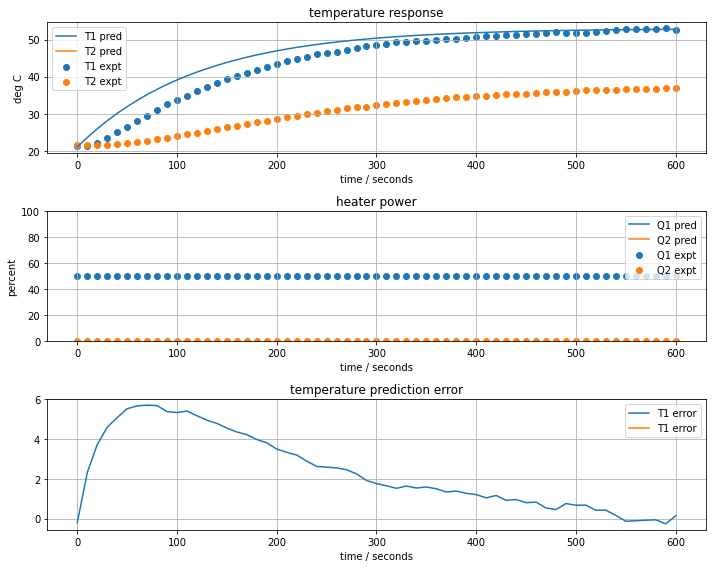

In [333]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# adjustable parameters
Cp = 6                 # joules/deg C
Ua = 0.05              # watts/deg C

# create a list of parameter values
param = [Cp, Ua]

def model_first_order(param, plot=False):
    # unpack the adjustable parameters
    Cp, Ua = param

    # model solution
    def deriv(t, y):
        T1_deviation = y[0]
        return -(Ua/Cp)*T1_deviation + (alpha*P1/Cp)*u1(t) + (Ua/Cp)*T_amb

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [T_amb], t_eval=t_expt) 
    
    # create dataframe with predictions
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T1"] = soln.y[0]

    # plot solution
    if plot:
        ax = plot_data(expt, pred)
    
    # compute sum of squares error
    err = ((pred["T1"] - expt["T1"])**2).sum()
        
    return err
    
model_first_order(param, plot=True)

## 2.4.7 Find the best fit

[6.00571894 0.05332656]


438.0778981192412

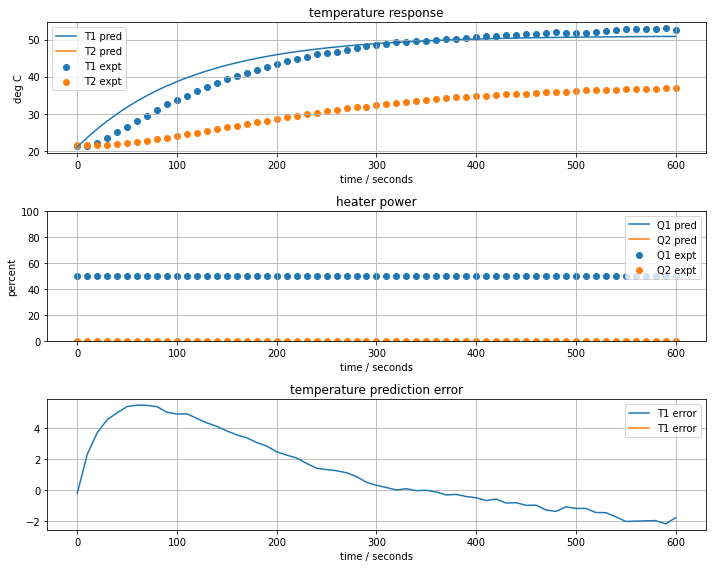

In [334]:
from scipy.optimize import least_squares

result = least_squares(model_first_order, param)
print(result.x)
model_first_order(result.x, plot=True)

## 2.4.8 Second-order model

### 2.4.8.1 Dynamics of the Heater/Sensor System

The previous results are not yet fully satisfactory. We're still missing the initial 'lag' in response of the measured temperature. 

For this third model, we consider the possibility that the heater and sensor may not be at the same temperature. In other words, that the heater/sensor assembly is not at a uniform temperature. To account for this possibility, we introduce $T_{H,1}$ to denote the temperature of heater one and $T_{S,1}$ to denote the temperature of the corresponding sensor. We'll further assume that sensor mainly exchanges heat with the heater, and the dominant heat transfer to the surroundings is through the heat sink attached to the heater.

This motivates a model

\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + \alpha P_1u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1}) 
\end{align}

where $C^H_p$ and $C^S_p$ are the gross heat capacities of the heater and sensor, respectively, and $U_b$ is a new heat transfer coefficient characterizing the exchange of heat between the heater and sensor.

\begin{align}
\frac{dT_{H,1}}{dt} & = -\frac{U_a+U_b}{C^H_p}T_{H,1} + \frac{U_b}{C^H_p}T_{S,1} + \frac{\alpha P_1}{C^H_p}u_1 + \frac{U_a}{C^H_p}T_{amb}\\
\frac{dT_{S,1}}{dt} & = \frac{U_b}{C^S_p}(T_{H,1} - T_{S,1}) 
\end{align}

Where measured temperature, that is, the temperature recorded by the Arduino, $T_1$ is given by

$$T_1 = T_{S,1}$$

167.45173123127609

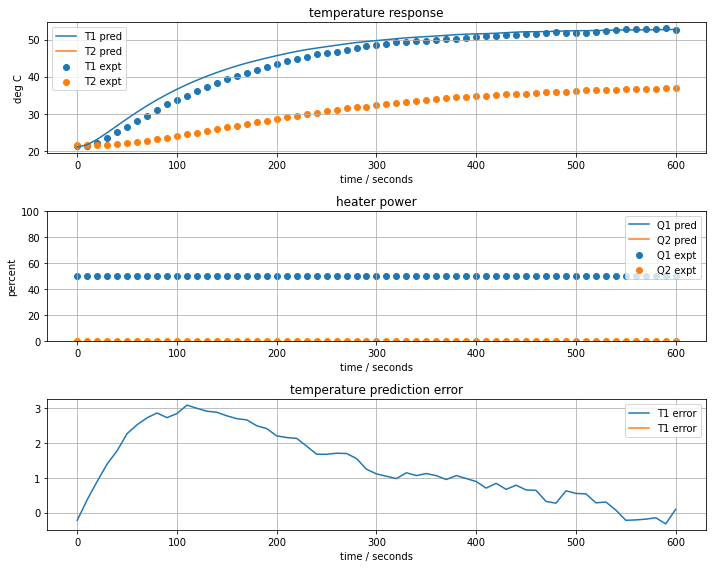

In [325]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# adjustable parameters
CpH = 5                # joules/deg C
CpS = 1                # joules/deg C
Ua = 0.05              # watts/deg C
Ub = 0.05              # watts/deg C

# create a list of parameter values
param = [CpH, CpS, Ua, Ub]

def model_second_order(param, plot=False):
    # unpack the adjustable parameters
    CpH, CpS, Ua, Ub = param

    # model solution
    def deriv(t, y):
        T1H, T1S = y
        dT1H = (-(Ua + Ub)*T1H + Ub*T1S + alpha*P1*u1(t) + Ua*T_amb)/CpH
        dT1S = Ub*(T1H - T1S)/CpS
        return [dT1H, dT1S]

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [T_amb, T_amb], t_eval=t_expt) 
    
    # create dataframe with predictions
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T1"] = soln.y[1]

    # plot solution
    if plot:
        ax = plot_data(expt, pred)
    
    # compute sum of squares error
    err = ((pred["T1"] - expt["T1"])**2).sum()
        
    return err
    
model_second_order(param, plot=True)

### 2.4.8.2 Best fit

[5.00071252 1.00177015 0.05020608 0.02242074]


3.618490193825922

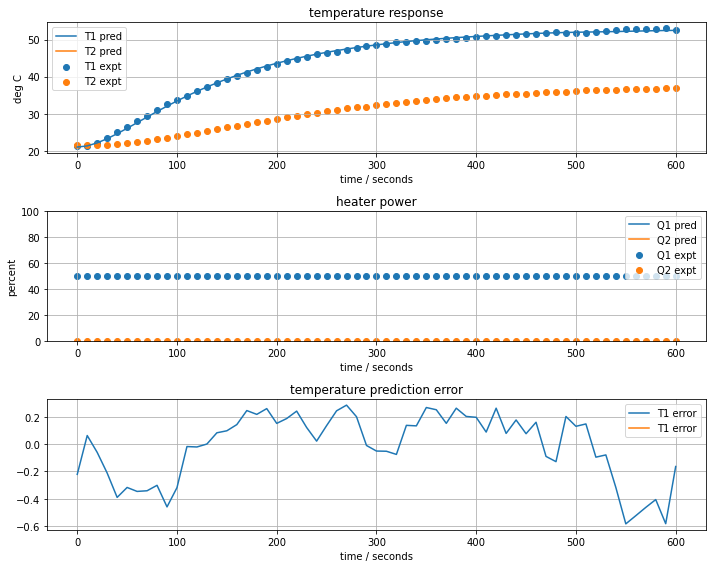

In [326]:
result = least_squares(model_second_order, param)
print(result.x)
model_second_order(result.x, plot=True)

## 2.4.9 Fourth-Order Multi-Input Multi-Output Model

### 2.4.9.1 Model derivation

\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + U_c(T_{H,2}-T_{H,1})  + \alpha P_1u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1})  \\
C^H_p\frac{dT_{H,2}}{dt} & = U_a(T_{amb} - T_{H,2}) + U_b(T_{S,2} - T_{H,2}) + U_c(T_{H,1}-T_{H,2}) + \alpha P_2 u_2\\
C^S_p\frac{dT_{S,2}}{dt} & = U_b(T_{H,2} - T_{S,2}) 
\end{align}

where

\begin{align}
T_1 & = T_{S,1} \\
T_2 & = T_{S,2}
\end{align}

### 2.4.9.2 Standard form

\begin{align}
\frac{dT_{H,1}}{dt} & = -(\frac{U_a+U_b+U_c}{C^H_p})T_{H,1} + \frac{U_b}{C^H_p}T_{S,1} + \frac{U_c}{C^H_p}T_{H,2}  + \frac{\alpha P_1}{C^H_p}u_1 + \frac{U_a}{C^H_p}T_{amb}\\
\frac{dT_{S,1}}{dt} & = \frac{U_b}{C^S_p}(T_{H,1} - T_{S,1})  \\
\frac{dT_{H,2}}{dt} & = -(\frac{U_a+U_b+U_c}{C^H_p})T_{H,2} + \frac{U_b}{C^H_p}T_{S,2} + \frac{U_c}{C^H_p}T_{H,1}  + \frac{\alpha P_2}{C^H_p}u_2 + \frac{U_a}{C^H_p}T_{amb}\\
\frac{dT_{S,2}}{dt} & = \frac{U_b}{C^S_p}(T_{H,2} - T_{S,2}) 
\end{align}

where

\begin{align}
T_1 & = T_{S,1} \\
T_2 & = T_{S,2}
\end{align}

7674.3821283240395

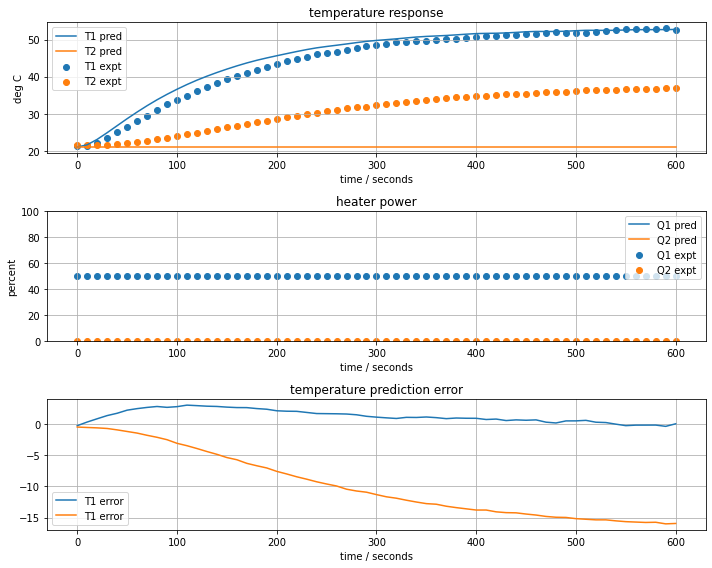

In [327]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# adjustable parameters
CpH = 5                # joules/deg C
CpS = 1                # joules/deg C
Ua = 0.05              # watts/deg C
Ub = 0.05              # watts/deg C
Uc = 0.00              # watts/deg C

# create a list of parameter values
param = [CpH, CpS, Ua, Ub, Uc]

def model_fourth_order(param, plot=False):
    # unpack the adjustable parameters
    CpH, CpS, Ua, Ub, Uc = param  

    # model solution
    def deriv(t, y):
        T1H, T1S, T2H, T2S= y
        dT1H = (-(Ua + Ub + Uc)*T1H + Ub*T1S + Uc*T2H + alpha*P1*u1(t) + Ua*T_amb)/CpH
        dT1S = Ub*(T1H - T1S)/CpS
        dT2H = (-(Ua + Ub + Uc)*T2H + Ub*T2S + Uc*T1H + alpha*P2*u2(t) + Ua*T_amb)/CpH
        dT2S = Ub*(T2H - T2S)/CpS
        return [dT1H, dT1S, dT2H, dT2S]

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [T_amb]*4, t_eval=t_expt) 
    
    # create dataframe with predictions
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T1"] = soln.y[1]
    pred["T2"] = soln.y[3]

    # plot solution
    if plot:
        ax = plot_data(expt, pred)
    
    # compute sum of squares error
    err = ((pred["T1"] - expt["T1"])**2).sum() + ((pred["T2"] - expt["T2"])**2).sum()
        
    return err
    
model_fourth_order(param, plot=True)

[5.00015286 1.00081115 0.03126917 0.03063663 0.03422925]


9.987753349186374

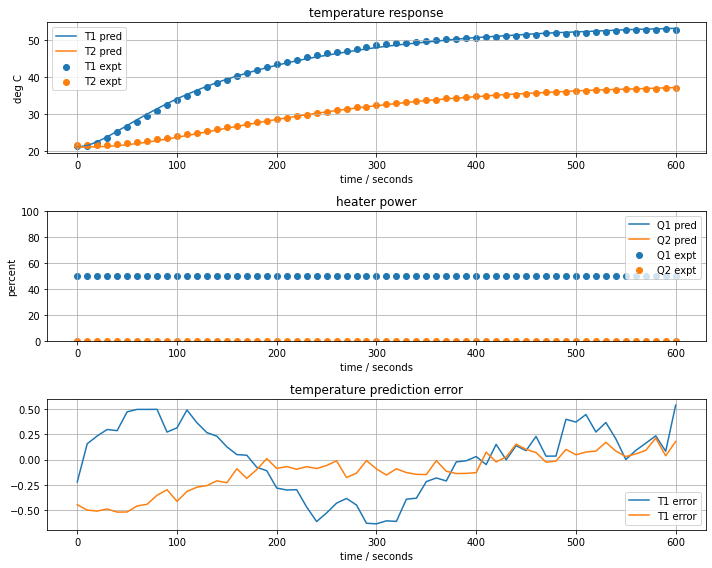

In [328]:
result = least_squares(model_fourth_order, param)
print(result.x)
model_fourth_order(result.x, plot=True)

## 2.4.10 Linear State Space models

As you can see, models quickly become cumbersome to formulate as we attempt to incorporate more detail. This version of a model Temperature Control Lab model application involves four states, two manipulable inputs, one disturbance $T_{amb}$. 

\begin{align}
\frac{d}{dt}\underbrace{\left[\begin{array}{c} T_{H,1} \\ T_{S,1} \\ T_{H,2} \\ T_{S,2} \end{array}\right]}_x
& = 
\underbrace{\left[\begin{array}{cccc}
-(\frac{U_a+U_b+U_c}{C^H_p}) & \frac{U_b}{C^H_p} & \frac{U_c}{C^H_p} & 0 \\
\frac{U_b}{C^S_p} & -\frac{U_b}{C^S_p} & 0 & 0 \\
\frac{U_c}{C^H_p} & 0 & -(\frac{U_a+U_b+U_c}{C^H_p}) & \frac{U_b}{C^H_p} \\
0 & 0 & \frac{U_b}{C^S_p} & -\frac{U_b}{C^S_p}
\end{array}\right]}_A
\underbrace{\left[\begin{array}{c}T_{H,1} \\ T_{S,1} \\ T_{H,2} \\ T_{S,2}\end{array}\right]}_x
+
\underbrace{\left[\begin{array}{cc}\frac{\alpha P_1}{C_p} & 0 \\ 0 & 0 \\ 0 & \frac{\alpha P_2}{C_p} \\ 0 & 0 \end{array}\right]}_{B_u}
\underbrace{\left[\begin{array}{c}u_1 \\ u_2\end{array}\right]}_u
+
\underbrace{\left[\begin{array}{c}\frac{U_a}{C^H_p} \\ 0 \\ \frac{U_a}{C^H_p} \\ 0 \end{array}\right]}_{B_d}
\underbrace{\left[\begin{array}{c}T_{amb}\end{array}\right]}_{d}
\end{align}

\begin{align}
\underbrace{\left[\begin{array}{c} T_1 \\ T_2 \end{array}\right]}_y
& = 
\underbrace{\left[\begin{array}{cccc} 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{array}\right]}_C
\underbrace{\left[\begin{array}{c}T_{H,1} \\ T_{S,1} \\ T_{H,2} \\ T_{S,2}\end{array}\right]}_x
\end{align}

\begin{align}
\frac{dx}{dt} & = A x + B_u u + B_d d \\
y & = C x
\end{align}

where

$$x = \left[\begin{array}{c}T_{H,1} \\ T_{S,1} \\ T_{H,2} \\ T_{S,2}\end{array}\right]
\qquad
u = \left[\begin{array}{c}u_1 \\ u_2\end{array}\right]
\qquad
d = \left[\begin{array}{c}T_{amb}\end{array}\right]
\qquad
y = \left[\begin{array}{c} T_1 \\ T_2 \end{array}\right]
$$

$$
A = \left[\begin{array}{cccc}
-(\frac{U_a+U_b+U_c}{C^H_p}) & \frac{U_b}{C^H_p} & \frac{U_c}{C^H_p} & 0 \\
\frac{U_b}{C^S_p} & -\frac{U_b}{C^S_p} & 0 & 0 \\
\frac{U_c}{C^H_p} & 0 & -(\frac{U_a+U_b+U_c}{C^H_p}) & \frac{U_b}{C^H_p} \\
0 & 0 & \frac{U_b}{C^S_p} & -\frac{U_b}{C^S_p}
\end{array}\right]
\qquad
B_u = \left[\begin{array}{cc}\frac{\alpha P_1}{C_p} & 0 \\ 0 & 0 \\ 0 & \frac{\alpha P_2}{C_p} \\ 0 & 0 \end{array}\right]
\qquad
B_d  = \left[\begin{array}{c}\frac{U_a}{C^H_p} \\ 0 \\ \frac{U_a}{C^H_p} \\ 0 \end{array}\right]
\qquad
C = \left[\begin{array}{cccc} 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{array}\right]
$$

[5.00015286 1.00081115 0.03126917 0.03063663 0.03422925]


9.987753349186374

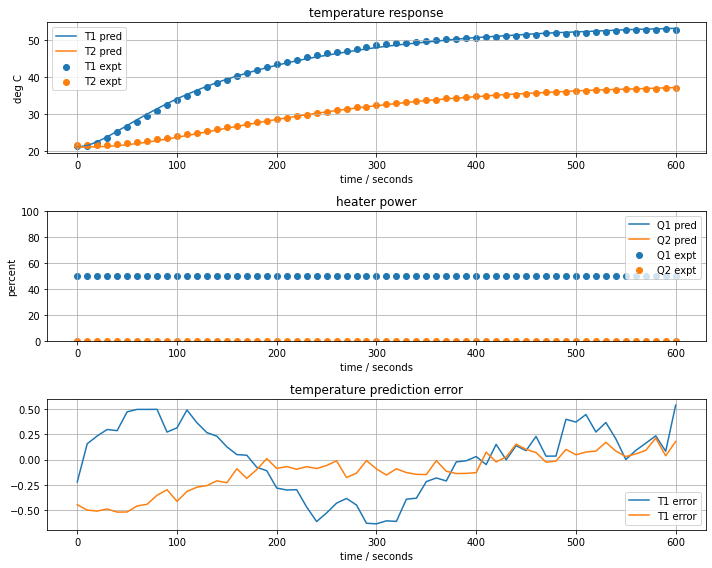

In [329]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# adjustable parameters
CpH = 5                # joules/deg C
CpS = 1                # joules/deg C
Ua = 0.05              # watts/deg C
Ub = 0.05              # watts/deg C
Uc = 0.00              # watts/deg C

# create a list of parameter values
param = [CpH, CpS, Ua, Ub, Uc]

def model_state_space(param, plot=False):
    # unpack the adjustable parameters
    CpH, CpS, Ua, Ub, Uc = param  
    
    A = np.array([
        [-(Ua + Ub + Uc)/CpH, Ub/CpH, Uc/CpH, 0],
        [Ub/CpS, -Ub/CpS, 0, 0],
        [Uc/CpH, 0, -(Ua + Ub + Uc)/CpH, Ub/CpH],
        [0, 0, Ub/CpS, -Ub/CpS]
    ])
    
    Bu = np.array([
        [alpha*P1/CpH, 0],
        [0, 0],
        [0, alpha*P2/CpH],
        [0, 0]
    ])
    
    Bd = np.array([[Ua/CpH], [0], [Ua/CpH], [0]])
    
    C = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])
    
    # model solution
    def deriv(t, y):
        u = np.array([u1(t), u2(t)])
        d = np.array([T_amb])
        return np.dot(A, y) + np.dot(Bu, u) + np.dot(Bd, d)

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [T_amb]*4, t_eval=t_expt) 
    
    # create dataframe with predictions
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T1"] = soln.y[1]
    pred["T2"] = soln.y[3]

    # plot solution
    if plot:
        ax = plot_data(expt, pred)
    
    # compute sum of squares error
    err = ((pred["T1"] - expt["T1"])**2).sum() + ((pred["T2"] - expt["T2"])**2).sum()
        
    return err
    
result = least_squares(model_fourth_order, param)
print(result.x)
model_fourth_order(result.x, plot=True)

<!--NAVIGATION-->
< [2.3 First Order Model for a Single Heater](https://jckantor.github.io/cbe30338-2021/02.03-First-Order-Model-for-a-Single-Heater.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [2.5 Two State Model for a Single Heater](https://jckantor.github.io/cbe30338-2021/02.05-Two-State-Model-for-a-Single-Heater.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/02.04-Model-Identification.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/02.04-Model-Identification.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>